# Import Packages

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u3933826/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from ALPackage.transformer import EMBALLayer, TransformerEncoderALLayer, TransformerEncoder
from utils import get_word_vector, get_nlp_data, set_device
from tqdm import tqdm
import time
import torch.nn as nn
import torch
import threading

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# Prepare data

In [4]:
class Args:
    def __init__(self, dataset, max_len, min_len = 1):
        self.dataset = dataset
        self.class_num = None
        self.batch_size = 256        
        self.max_len = max_len
        self.min_len = min_len
        self.vocab_size = 30000
        self.pretrained_embedding = None
        self.pretrained_model = None
        self.embedding_dim = 300
        self.x_hid = 256
        self.y_hid = 128
        self.n_heads = 6       
        self.dropout = 0.3
        self.lr = 0.00025
        self.epochs = 5
        self.act = nn.Tanh()

    def get_filename(self):
        name = f"{self.dataset},{self.batch_size},{self.max_len},{self.min_len},{self.x_hid},{self.y_hid}"
        return name
    
    def set_pretrained(self, vocab, emb):
        self.pretrained_embedding = get_word_vector(vocab, emb)
        self.pretrained_model = emb

In [5]:
args = Args('ag_news', 128)
train_loader, test_loader, class_num, vocab = get_nlp_data(args)
args.class_num = class_num
args.set_pretrained(vocab, emb='glove')

|========================= Load data:ag_news ========================================================|


Found cached dataset ag_news (/home/u3933826/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
Found cached dataset ag_news (/home/u3933826/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


|========================= Preprocessing ============================================================|
Original Data: 120000
Valid Data: 120000
total count words 102019
vocab size 30000


loading glove vocabs...: 100%|██████████| 400000/400000 [00:05<00:00, 72115.11it/s]


found 26754 words in glove


# Scale Test helper

In [6]:
class Transformer(nn.Module):
    def __init__(self, args, tr_num):
        super().__init__()
        self.seq = nn.ModuleList()
        if args.pretrained_embedding == None:
            self.seq.append(nn.Embedding(args.vocab_size, args.embedding_dim))
        else:
            self.seq.append(nn.Embedding.from_pretrained(args.pretrained_embedding, freeze=False))
        for _ in range(tr_num):        
            self.seq.append(TransformerEncoder(args.embedding_dim, args.x_hid, args.n_heads, 1, args.dropout))
        self.seq.append(nn.Sequential(
            nn.Linear(args.embedding_dim, args.class_num),
            nn.LogSoftmax(dim=1)
        ))
        self.device = ["cpu" for _ in range(len(self.seq))]

    def forward(self, x):
        mask = self.get_mask(x)

        # 1. Feed embedding layer
        x = self.seq[0](x.to(self.device[0]))

        # 2. Feed Transformer
        for i in range(1, len(self.seq)-1, 1):
            x = self.seq[i](x.to(self.device[i]), mask.to(self.device[i]))
        
        # 3. Feed fc layer
        x = x.to(self.device[-1])
        mask = mask.to(self.device[-1])
        feat = torch.sum(x*mask.unsqueeze(-1), dim=1) / torch.sum(mask, -1, keepdim=True)
        return self.seq[-1](feat)

    def get_mask(self, x):
        pad_mask = ~(x == 0)
        return pad_mask

In [7]:
class TransformerAL(nn.Module):
    def __init__(self, args, tr_num):
        super().__init__()
        self.seq = nn.ModuleList()
        self.seq.append(EMBALLayer(args.vocab_size, args.embedding_dim, args.class_num, args.y_hid, args.act, args.lr, args.pretrained_embedding))
        for _ in range(tr_num):
            self.seq.append(TransformerEncoderALLayer(args.embedding_dim, args.x_hid, args.y_hid, args.y_hid, args.act, args.lr, args.n_heads, 1, args.dropout))
        self.device = ["cpu" for i in range(len(self.seq))]

    def forward(self, x, y):
        mask = self.get_mask(x)

        # 1. Feed embedding layer
        x, y = self.seq[0](x.to(self.device[0]), y.to(self.device[0]))
        
        # 2. Feed Transformer
        for i in range(1, len(self.seq), 1):
            inputs = (x.to(self.device[i]), mask.to(self.device[i]))
            y = y.to(self.device[i])
            x, y = self.seq[i](inputs, y)

    def backward(self):
        for i in range(len(self.seq)):
            self.seq[i].backward()

    def update(self):
        for i in range(len(self.seq)):
            self.seq[i].update()

    def thread_backward_and_update(self):
        threads = []
        for i in range(len(self.seq)):
            threads.append(threading.Thread(target=self.seq[i].backward_and_update))
            threads[i].start()
        for i in range(len(self.seq)):
            threads[i].join()

    def thread_forward_backward_and_update(self, x, y):
        threads = []
        mask = self.get_mask(x)

        # 1. Feed embedding layer
        x, y = self.seq[0](x.to(self.device[0]), y.to(self.device[0]))
        threads.append(threading.Thread(target=self.seq[0].backward_and_update))
        threads[0].start()

        # 2. Feed Transformer
        for i in range(1, len(self.seq), 1):
            inputs = (x.to(self.device[i]), mask.to(self.device[i]))
            y = y.to(self.device[i])
            x, y = self.seq[i](inputs, y)
            threads.append(threading.Thread(target=self.seq[i].backward_and_update))
            threads[i].start()
        
        for i in range(len(self.seq)):
            threads[i].join()
    
    def loss(self):
        loss = {
            "enc_loss": [],
            "ae_loss": []
        }
        for i in range(len(self.seq)):
            enc_loss, ae_loss = self.seq[i].loss()
            loss['enc_loss'].append(enc_loss.item())
            loss['ae_loss'].append(ae_loss.item())
        return loss

    def inference(self, x):
        mask = self.get_mask(x)
        x = self.seq[0].inference(x.to(self.device[0]), 'f')
        for i in range(1, len(self.seq), 1):
            inputs = (x.to(self.device[i]), mask.to(self.device[i]))
            x = self.seq[i].inference(inputs, 'f')
        inputs = (x, mask.to(self.device[i]))
        x = self.seq[-1].inference(inputs, 'b')
        for i in range(len(self.seq)-1, -1, -1):
            x = x.to(self.device[i])
            x = self.seq[i].inference(x, 'h')
        return x

    def get_mask(self, x):
        pad_mask = ~(x == 0)
        return pad_mask

# Trainer

In [18]:
def Trainer(args, mode, device, tr_num):
    
    train_time = []
    
    if mode == "BP":
        model = Transformer(args, tr_num)
        set_device(model, device)
        optimizer = torch.optim.Adam(model.parameters(), args.lr)
        loss_fn = nn.NLLLoss()
        
        for epoch in range(args.epochs):
            model.train()
            torch.cuda.synchronize()
            start = time.time()
            for inputs, labels in tqdm(train_loader):            
                labels = labels.to(device[-1])
                pred = model(inputs)
                loss_fn(pred, labels).backward()
                optimizer.step()
                optimizer.zero_grad()
            torch.cuda.synchronize()
            end = time.time()
            train_time.append(end-start)
                
    elif mode == "AL":
        model = TransformerAL(args, tr_num)
        set_device(model, device)
        for epoch in range(args.epochs):
            model.train()
            torch.cuda.synchronize()
            start = time.time()
            for inputs, labels in tqdm(train_loader):
                y = torch.nn.functional.one_hot(labels, args.class_num).float()
                model.thread_forward_backward_and_update(inputs, y)
            torch.cuda.synchronize()
            end = time.time()
            train_time.append(end-start)
    
    return np.mean(train_time), np.std(train_time)     

# Scaling Test

In [19]:
def Scale():
    
    '''
    Weak: Add layers, add GPU
    x: number of layers
    y: execution time
    method: gpu_num

    1 gpu with 1x layers
    2 gpu with 2x layers
    ...
    6 gpu with 6x layers 

    ===================================

    Strong: Fix layers, add gpu
    x: number of gpu
    y: execution time
    method: number of layers

    6 layers with 1, 2, 3, 6 gpus
    12 layers with 1, 2, 3, 4, 6 gpus
    '''    
    
    gpus = {
        "1":[[0],[0,0],[0,0,0],[0,0,0,0],[0,0,0,0,0],[0,0,0,0,0,0],
             [0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0]],
        "2":[[0,1],[0,1,0,1],[0,1,0,1,0,1],[0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0,1]],
        "3":[[0,1,2],[0,1,2,0,1,2],[0,1,2,0,1,2,0,1,2],[0,1,2,0,1,2,0,1,2,0,1,2]],
        "4":[[0,1,2,3],[0,1,2,3,0,1,2,3],[0,1,2,3,0,1,2,3,0,1,2,3]],
        "5":[[0,1,2,3,4],[0,1,2,3,4,0,1,2,3,4]],
        "6":[[0,1,2,3,4,5],[0,1,2,3,4,5,0,1,2,3,4,5]]
    }

    key = []
    bp = []
    al = []
    
    try:
        mode = "BP"
        for gpu, layers in gpus.items():
            for layer in layers:
                n = len(layer)
                device = ['cuda:0']
                for l in layer:
                    device.append(f"cuda:{l}")
                device.append(f"cuda:{layer[-1]}")
                mean, std = Trainer(args, mode, device, n)
                bp.append(f"{mean:.4f}±{std:.4f}")
                print(f"BP {gpu}gpu_{n}Trlayers:{mean:.4f}±{std:.4f}")
            
        mode = "AL"    
        for gpu, layers in gpus.items():
            for layer in layers:
                n = len(layer)
                device = ['cuda:0']
                for l in layer:
                    device.append(f"cuda:{l}")
                mean, std = Trainer(args, mode, device, n)
                al.append(f"{mean:.4f}±{std:.4f}")
                print(f"AL {gpu}gpu_{n}Trlayers:{mean:.4f}±{std:.4f}")

        for gpu, layers in gpus.items():
            for layer in layers:
                n = len(layer)
                key.append(f"{gpu}gpu_{n}Trlayers")

        result = {
            "key": key,
            "bp": bp,
            "al": al
        }  

        df = pd.DataFrame(result)
        df.to_csv(f"Scale.csv", index=False)
        return bp, al

    except Exception as e:
        print(e)      
        return bp, al

In [20]:
bp, al = Scale()

100%|██████████| 469/469 [00:08<00:00, 54.60it/s]


BP 1gpu_1Trlayers:8.6685±0.1149


100%|██████████| 469/469 [00:14<00:00, 31.28it/s]


BP 1gpu_2Trlayers:15.1605±0.3761


100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


BP 1gpu_3Trlayers:21.5682±0.0403


100%|██████████| 469/469 [00:28<00:00, 16.53it/s]


BP 1gpu_4Trlayers:28.2956±0.0519


100%|██████████| 469/469 [00:34<00:00, 13.58it/s]


BP 1gpu_5Trlayers:34.7366±0.1070


100%|██████████| 469/469 [00:41<00:00, 11.41it/s]


BP 1gpu_6Trlayers:41.1455±0.0843


100%|██████████| 469/469 [00:47<00:00,  9.89it/s]


BP 1gpu_7Trlayers:47.7362±0.5556


100%|██████████| 469/469 [00:53<00:00,  8.75it/s]


BP 1gpu_8Trlayers:53.9002±0.1978


100%|██████████| 469/469 [00:59<00:00,  7.83it/s]


BP 1gpu_9Trlayers:60.3925±0.5930


100%|██████████| 469/469 [01:05<00:00,  7.12it/s]


BP 1gpu_10Trlayers:66.1035±0.1727


100%|██████████| 469/469 [01:11<00:00,  6.52it/s]


BP 1gpu_11Trlayers:72.5862±1.0104


100%|██████████| 469/469 [01:18<00:00,  5.94it/s]


BP 1gpu_12Trlayers:78.5170±0.2529


100%|██████████| 469/469 [00:15<00:00, 29.57it/s]


BP 2gpu_2Trlayers:16.0708±0.2255


100%|██████████| 469/469 [00:31<00:00, 15.06it/s]


BP 2gpu_4Trlayers:31.0329±0.0932


100%|██████████| 469/469 [00:46<00:00, 10.15it/s]


BP 2gpu_6Trlayers:45.7447±0.4431


100%|██████████| 469/469 [00:59<00:00,  7.84it/s]


BP 2gpu_8Trlayers:60.0061±0.4893


100%|██████████| 469/469 [01:13<00:00,  6.42it/s]


BP 2gpu_10Trlayers:73.1462±0.2567


100%|██████████| 469/469 [01:28<00:00,  5.29it/s]


BP 2gpu_12Trlayers:87.1229±0.8418


100%|██████████| 469/469 [00:24<00:00, 19.07it/s]


BP 3gpu_3Trlayers:24.5356±0.0995


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


BP 3gpu_6Trlayers:47.4251±0.4295


100%|██████████| 469/469 [01:09<00:00,  6.77it/s]


BP 3gpu_9Trlayers:69.8119±0.4838


100%|██████████| 469/469 [01:31<00:00,  5.11it/s]


BP 3gpu_12Trlayers:91.2259±0.3370


100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


BP 4gpu_4Trlayers:32.4574±0.4531


100%|██████████| 469/469 [01:00<00:00,  7.71it/s]


BP 4gpu_8Trlayers:61.5525±0.4182


100%|██████████| 469/469 [01:28<00:00,  5.27it/s]


BP 4gpu_12Trlayers:89.0970±0.2155


100%|██████████| 469/469 [00:40<00:00, 11.45it/s]


BP 5gpu_5Trlayers:40.8333±0.0820


100%|██████████| 469/469 [01:20<00:00,  5.80it/s]


BP 5gpu_10Trlayers:80.3244±0.5639


100%|██████████| 469/469 [00:48<00:00,  9.66it/s]


BP 6gpu_6Trlayers:48.0672±0.3200


100%|██████████| 469/469 [01:35<00:00,  4.91it/s]


BP 6gpu_12Trlayers:94.1557±0.6535


100%|██████████| 469/469 [00:07<00:00, 62.95it/s]


AL 1gpu_1Trlayers:7.4422±0.0316


100%|██████████| 469/469 [00:12<00:00, 38.18it/s]


AL 1gpu_2Trlayers:12.3406±0.0523


100%|██████████| 469/469 [00:17<00:00, 26.48it/s]


AL 1gpu_3Trlayers:17.7225±0.0641


100%|██████████| 469/469 [00:23<00:00, 20.35it/s]


AL 1gpu_4Trlayers:23.0861±0.0671


100%|██████████| 469/469 [00:28<00:00, 16.47it/s]


AL 1gpu_5Trlayers:28.4502±0.0674


100%|██████████| 469/469 [00:33<00:00, 13.79it/s]


AL 1gpu_6Trlayers:33.9025±0.0652


100%|██████████| 469/469 [00:39<00:00, 11.92it/s]


AL 1gpu_7Trlayers:39.4354±0.1062


100%|██████████| 469/469 [00:44<00:00, 10.49it/s]


AL 1gpu_8Trlayers:44.7524±0.1310


100%|██████████| 469/469 [00:50<00:00,  9.34it/s]


AL 1gpu_9Trlayers:50.1453±0.1593


100%|██████████| 469/469 [00:55<00:00,  8.40it/s]


AL 1gpu_10Trlayers:55.6442±0.0895


100%|██████████| 469/469 [01:01<00:00,  7.66it/s]


AL 1gpu_11Trlayers:60.9667±0.1385


100%|██████████| 469/469 [01:06<00:00,  7.09it/s]


AL 1gpu_12Trlayers:66.2006±0.1709


100%|██████████| 469/469 [00:09<00:00, 51.58it/s]


AL 2gpu_2Trlayers:9.5381±0.2422


100%|██████████| 469/469 [00:19<00:00, 23.85it/s]


AL 2gpu_4Trlayers:19.7004±0.1240


100%|██████████| 469/469 [00:30<00:00, 15.18it/s]


AL 2gpu_6Trlayers:31.0750±0.2276


100%|██████████| 469/469 [00:42<00:00, 11.03it/s]


AL 2gpu_8Trlayers:42.5375±0.1133


100%|██████████| 469/469 [00:53<00:00,  8.70it/s]


AL 2gpu_10Trlayers:54.0838±0.2859


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


AL 2gpu_12Trlayers:65.4556±0.2552


100%|██████████| 469/469 [00:11<00:00, 39.37it/s]


AL 3gpu_3Trlayers:11.9558±0.0979


100%|██████████| 469/469 [00:24<00:00, 19.11it/s]


AL 3gpu_6Trlayers:24.7074±0.1899


100%|██████████| 469/469 [00:39<00:00, 11.78it/s]


AL 3gpu_9Trlayers:40.1107±0.2646


100%|██████████| 469/469 [00:55<00:00,  8.52it/s]


AL 3gpu_12Trlayers:55.5893±0.3054


100%|██████████| 469/469 [00:15<00:00, 29.98it/s]


AL 4gpu_4Trlayers:15.5513±0.0751


100%|██████████| 469/469 [00:32<00:00, 14.38it/s]


AL 4gpu_8Trlayers:33.0590±0.5336


100%|██████████| 469/469 [00:50<00:00,  9.31it/s]


AL 4gpu_12Trlayers:51.0519±0.7986


100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


AL 5gpu_5Trlayers:21.0439±0.1978


100%|██████████| 469/469 [00:50<00:00,  9.25it/s]


AL 5gpu_10Trlayers:50.1382±0.9243


100%|██████████| 469/469 [00:25<00:00, 18.09it/s]


AL 6gpu_6Trlayers:26.2323±0.6030


100%|██████████| 469/469 [00:57<00:00,  8.16it/s]

AL 6gpu_12Trlayers:60.8546±2.3844


# Preview

In [14]:
def CalculateSpeedUp(time):
    speedup = []
    for t in time:
        speedup.append(time[0]/t)
    return speedup

In [15]:
def plotGraph(bp, al, title):
    
    if len(bp)==6:
        gpu = [1, 2, 3, 4, 5, 6]
        xlabel = "Number of GPUs & task size"
    else:
        gpu = [1, 2, 3, 4, 6]
        xlabel = "Number of GPUs"
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    fig.suptitle(title)

    # 繪製子圖A
    axs[0].plot(gpu, bp, label="BP")
    axs[0].plot(gpu, al, label="AL")
    axs[0].set_ylabel('Execution Time')
    axs[0].set_xlabel(xlabel)
    axs[0].legend()

    # 繪製子圖B
    axs[1].plot(gpu, CalculateSpeedUp(bp), label="BP")
    axs[1].plot(gpu, CalculateSpeedUp(al), label="AL")
    axs[1].set_ylabel('Speedup')
    axs[1].set_xlabel(xlabel)
    axs[1].legend()

    # 顯示圖表
    plt.savefig(f"{title}.pdf", format="pdf")
    plt.show()   

In [16]:
def readResults(filename):
    
    df = pd.read_csv(filename)
    bp = []
    al = []
    for _, row in df.iterrows():
        bp.append(float(row["bp"].split("±")[0]))
        al.append(float(row["al"].split("±")[0]))
        
    plotGraph(bp, al, filename.split(".csv")[0])        

In [17]:
def getMean(string):
    return float(string.split("±")[0])

# WeakScale

In [18]:
def WeakScalePreview():
    '''
    Graph 1: Time/Speedup(y) with different number of layers/gpus(x)
    Data:
    (1,1),(2,2),(3,3),(4,4),(5,5),(6,6)

    Chart 1: Time/Speedup(BPvsAL) with different number of layers/gpus

    Graph 2: Different number of gpus(label), Time(y) with different number of layers(x)
    Data:
    (1,1~12)
    (2,2~12)
    (3,3~12)
    (6,6~12)
    '''

    data = pd.read_csv("Scale.csv", index_col = 0).to_dict("index")

    # graph 1 
    bp = []
    al = []
    for i in range(1,7,1):
        key = f"{i}gpu_{i}Trlayers"
        bp.append(getMean(data[key]["bp"]))
        al.append(getMean(data[key]["al"]))
    plotGraph(bp, al, "WeakScale")

    # chart 1
    bpSpeedup = CalculateSpeedUp(bp)
    alSpeedup = CalculateSpeedUp(al)
    bp = []
    al = []
    gpu = []
    speedup = []
    for i in range(1,7,1):
        key = f"{i}gpu_{i}Trlayers"
        bp.append(data[key]["bp"])
        al.append(data[key]["al"])
        gpu.append(i)
        speedup.append(getMean(data[key]["bp"]) / getMean(data[key]["al"]))
    res = {
        "Number of encoder & GPUs ":gpu,
        "BP":bp,
        "AL":al,
        "SpeedUp(BP[0] / BP[i])":bpSpeedup,
        "SpeedUp(AL[0] / AL[i])":alSpeedup,
        "SpeedUp(BP / AL)":speedup
    }
    print(pd.DataFrame(res).to_latex(index=False))

    # graph 2
    bp = defaultdict(list)
    al = defaultdict(list)
    for i in range(1,7,1):
        for j in range(i, 13, i):
            key = f"{i}gpu_{j}Trlayers"
            bp[i].append(getMean(data[key]["bp"]))
            al[i].append(getMean(data[key]["al"]))
    
    plt.plot([i for i in range(1,13,1)], bp[1], label="BP with 1GPU & task size m", marker=".")
    plt.plot([i for i in range(2,13,2)], bp[2], label="BP with 2GPU & task size 2m", marker=".")
    plt.plot([i for i in range(3,13,3)], bp[3], label="BP with 3GPU & task size 3m", marker=".")
    plt.plot([i for i in range(6,13,6)], bp[6], label="BP with 6GPU & task size 6m", marker=".")
    plt.plot([i for i in range(1,13,1)], al[1], label="AL with 1GPU & task size m", marker="X")
    plt.plot([i for i in range(2,13,2)], al[2], label="AL with 2GPU & task size 2m", marker="X")
    plt.plot([i for i in range(3,13,3)], al[3], label="AL with 3GPU & task size 3m", marker="X")
    plt.plot([i for i in range(6,13,6)], al[6], label="AL with 6GPU & task size 6m", marker="X")
    plt.ylabel('Execution Time')
    plt.xlabel('Number of Encoders')
    plt.legend()
    plt.savefig("WeakScale2.pdf", format="pdf")
    plt.show()

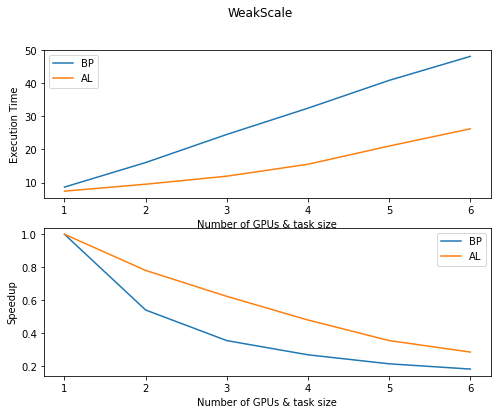

\begin{tabular}{rllrrr}
\toprule
 Number of encoder \& GPUs  &             BP &             AL &  SpeedUp(BP[0] / BP[i]) &  SpeedUp(AL[0] / AL[i]) &  SpeedUp(BP / AL) \\
\midrule
                         1 &  8.6685±0.1149 &  7.4422±0.0316 &                1.000000 &                1.000000 &          1.164777 \\
                         2 & 16.0708±0.2255 &  9.5381±0.2422 &                0.539394 &                0.780260 &          1.684906 \\
                         3 & 24.5356±0.0995 & 11.9558±0.0979 &                0.353303 &                0.622476 &          2.052192 \\
                         4 & 32.4574±0.4531 & 15.5513±0.0751 &                0.267073 &                0.478558 &          2.087118 \\
                         5 & 40.8333±0.0820 & 21.0439±0.1978 &                0.212290 &                0.353651 &          1.940387 \\
                         6 & 48.0672±0.3200 & 26.2323±0.6030 &                0.180341 &                0.283704 &          1.832367 \\
\bott

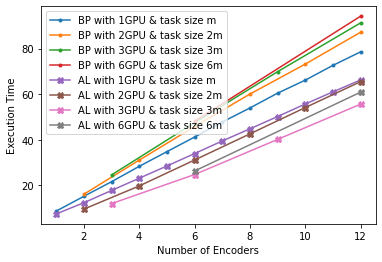

In [19]:
WeakScalePreview()

In [20]:
def StrongScalePreview():
    '''
    Graph 1: Time/Speedup(y) with different number of gpus(x)
    Data:
    (1,12),(2,12),(3,12),(4,12),(6,12)

    Chart 1: Time/Speedup(BPvsAL) with different number of gpus

    Graph 2: Different number of layers(label), Time(y) with different number of gpus(x)
    Data:
    (1,4), (2,4), (4,4)
    (1,6), (2,6), (3,6), (6,6)
    (1,8), (2,8), (4,8)
    (1,12), (2,12), (3,12), (4,12), (6,12)
    '''

    data = pd.read_csv("Scale.csv", index_col = 0).to_dict("index")

    # graph 1
    bp = []
    al = []
    for i in [1,2,3,4,6]:
        key = f"{i}gpu_12Trlayers"
        bp.append(getMean(data[key]["bp"]))
        al.append(getMean(data[key]["al"]))
    plotGraph(bp, al, "StrongScale")

    # chart 1
    bpSpeedup = CalculateSpeedUp(bp)
    alSpeedup = CalculateSpeedUp(al)
    bp = []
    al = []
    gpu = []
    speedup = []
    for i in [1,2,3,4,6]:
        key = f"{i}gpu_12Trlayers"
        bp.append(data[key]["bp"])
        al.append(data[key]["al"])
        gpu.append(i)
        speedup.append(getMean(data[key]["bp"]) / getMean(data[key]["al"]))
    res = {
        "Number of gpus":gpu,
        "BP":bp,
        "AL":al,
        "SpeedUp(BP[0] / BP[i])":bpSpeedup,
        "SpeedUp(AL[0] / AL[i])":alSpeedup,
        "SpeedUp(BP / AL)":speedup
    }
    print(pd.DataFrame(res).to_latex(index=False))

    # graph 2
    bp = defaultdict(list)
    al = defaultdict(list)
    for i in [4,6,8,12]:
        for j in [1,2,3,4,6]:
            if i % j == 0:
                key = f"{j}gpu_{i}Trlayers"
                bp[i].append(getMean(data[key]["bp"]))
                al[i].append(getMean(data[key]["al"]))
    
    plt.plot([1,2,4], bp[4], label="BP with 4Layers", marker=".")
    plt.plot([1,2,3,6], bp[6], label="BP with 6Layers", marker=".")
    plt.plot([1,2,4], bp[8], label="BP with 8Layers", marker=".")
    plt.plot([1,2,3,4,6], bp[12], label="BP with 12Layers", marker=".")
    plt.plot([1,2,4], al[4], label="AL with 4Layers", marker="X")
    plt.plot([1,2,3,6], al[6], label="AL with 6Layers", marker="X")
    plt.plot([1,2,4], al[8], label="AL with 8Layers", marker="X")
    plt.plot([1,2,3,4,6], al[12], label="AL with 12Layers", marker="X")
    plt.ylabel('Execution Time')
    plt.xlabel('Number of GPUs')
    plt.legend()
    plt.savefig("StrongScale2.pdf", format="pdf")
    plt.show()

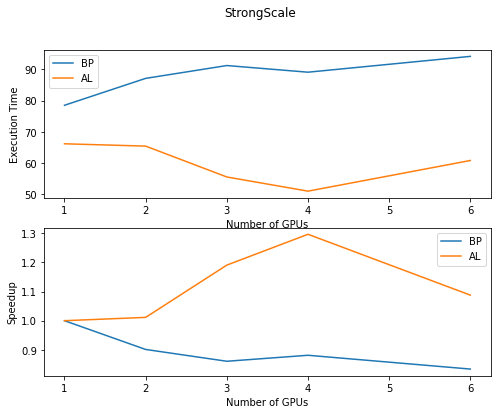

\begin{tabular}{rllrrr}
\toprule
 Number of gpus &             BP &             AL &  SpeedUp(BP[0] / BP[i]) &  SpeedUp(AL[0] / AL[i]) &  SpeedUp(BP / AL) \\
\midrule
              1 & 78.5170±0.2529 & 66.2006±0.1709 &                1.000000 &                1.000000 &          1.186047 \\
              2 & 87.1229±0.8418 & 65.4556±0.2552 &                0.901221 &                1.011382 &          1.331023 \\
              3 & 91.2259±0.3370 & 55.5893±0.3054 &                0.860688 &                1.190887 &          1.641069 \\
              4 & 89.0970±0.2155 & 51.0519±0.7986 &                0.881253 &                1.296731 &          1.745224 \\
              6 & 94.1557±0.6535 & 60.8546±2.3844 &                0.833906 &                1.087849 &          1.547224 \\
\bottomrule
\end{tabular}



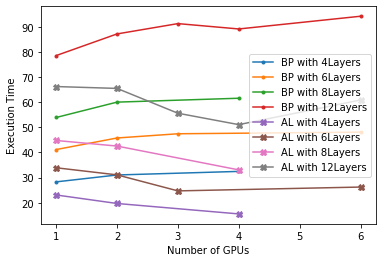

In [21]:
StrongScalePreview()

## Debug

In [10]:
from torch.profiler import profile, record_function, ProfilerActivity

In [11]:
def debugger(args, mode, device, tr_num):
    model = TransformerAL(args, tr_num)
    d = set(device)
    set_device(model, device)
    model.train()
    torch.cuda.synchronize()
    start = time.time()
    count = 0
    for inputs, labels in train_loader:
        if count < 1:
            with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
                y = torch.nn.functional.one_hot(labels, args.class_num).float()
                model.thread_forward_backward_and_update(inputs, y)
            prof.export_chrome_trace(f"{mode}_{len(d)}.json")
            count += 1
        else:
            break
    torch.cuda.synchronize()
    end = time.time()

In [17]:
gpus = {
        "1":[[0,0,0,0,0,0,0,0,0,0,0,0]],
        "2":[[0,1,0,1,0,1,0,1,0,1,0,1]],
        "3":[[0,1,2,0,1,2,0,1,2,0,1,2]],
        "4":[[0,1,2,3,0,1,2,3,0,1,2,3]],
        "6":[[0,1,2,3,4,5,0,1,2,3,4,5]]
}
for i in range(1,7):
    if i == 5:continue
    device = ['cuda:0']
    for l in gpus[f"{i}"][-1]:
        device.append(f"cuda:{l}")
    debugger(args, "TransformerAL", device, 12)

STAGE:2023-06-03 14:29:28 125:125 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-06-03 14:29:28 125:125 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-06-03 14:29:29 125:125 output_json.cpp:417] Completed Stage: Post Processing
STAGE:2023-06-03 14:29:29 125:125 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-06-03 14:29:29 125:125 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-06-03 14:29:30 125:125 output_json.cpp:417] Completed Stage: Post Processing
STAGE:2023-06-03 14:29:30 125:125 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-06-03 14:29:30 125:125 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-06-03 14:29:31 125:125 output_json.cpp:417] Completed Stage: Post Processing
STAGE:2023-06-03 14:29:31 125:125 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-06-03 14:29:31 125:125 ActivityProfilerController.c

In [16]:
device = ['cuda:0','cuda:0','cuda:1','cuda:2','cuda:3']
debugger(args, "TransformerAL", device, 4)

STAGE:2023-06-03 14:26:47 125:125 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-06-03 14:26:47 125:125 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-06-03 14:26:47 125:125 output_json.cpp:417] Completed Stage: Post Processing
